### Setup

In [2]:
import os, time, umap, math
import scipy.stats, scipy.signal
import numpy as np
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

##### Entropy Utility Functions

In [3]:
IQR = lambda X: np.quantile(X,.75) - np.quantile(X,.25)     # interquartile range
outlier = lambda X: X>(np.quantile(X,.75) +IQR(X))          # boolean outlier identification

def PMF(waveform):                  # probability mass function of waveform
    hist = histogram(waveform)      # histogram of waveform
    return hist / sum(hist)         # normalize to sum of 1
    
def histogram(wave):
    "Returns a histogram of values with bin widths determined by the Freedman-Diaconis rule."
    n = wave.shape[0]                               # number of points in time series
    data_range = np.max(wave) - np.min(wave)        # range of voltage values
    bin_width = 2 * IQR(wave) / (n ** (1 / 3))      # width of each bin
    num_bins = math.ceil(data_range / bin_width)    # number of bins
    edges = bin_width*np.arange(num_bins+1)         # bin boundaries
    # return number of points in each bin
    return np.array([np.count_nonzero((edges[i]<=wave) & (wave<edges[i+1])) for i in range(num_bins)])

##### Hit Class

In [185]:
class Hit:
    "A waveform with a fixed number of voltage values over time, and associated metadata and calculated values."
    def __init__(self, test=-1):
        self.text_file = None                   # .txt datafile containing waveform
        self.waveform = None                    # array containing the waveform voltage data
        self.test = test                        # test/data grouping number or identifier
        self.time = None                        # time at which the hit occured during the test, seconds
        self.duration = None                    # number of data points for which the hit continues before the HLT is triggered
        self.interval = None                    # sampling interval of the AE sensor
        self.number = None                      # number of hits on this channel and test, prior to and including this hit
        self.channel = None                     # channel of the AE sensor
        self.amplitude = None                   # approximate maximum amplitude of the hit
        self.entropy = None                     # information entropy of voltage PMF for the hit
        self.spectrogram = None                 # spectrogram of the hit
        self.normalized = None                  # log-normalized spectrogram
        self.latent = None                      # latent space vector from autoencoder model
        self.flat = None                        # flattened latente space generated with umap
        self.decoded = None                     # regenerated spectrogram from autoencoder model

    def calculate_all(self):
        "Calculate all relevant values for the dataset"
        self.get_duration()                     # determine the duration of each hit
        self.get_spectrogram()                  # get the spectrogram for the hit
        self.get_entropy()                      # get the entropy value of the hit
        self.get_amplitude()                    # get the amplitude of the hit
    
    def get_spectrogram(self) -> np.ndarray:
        "Calculate a spectrogram of the waveform using scipy function"
        if self.spectrogram is None:
            self.spectrogram = scipy.signal.spectrogram(self.waveform, nperseg=120)[2]
        return self.spectrogram
    
    def get_duration(self) -> int:
        "Calculate the number of points in the waveform, excluding the trailing HLT"
        if self.duration is None:
            index = -1                      # start checking from end
            while self.waveform[index]==0:  # while no nonzero entries have been found
                index -= 1                  # iterate backwards through wave
            self.duration = index + len(self.waveform)
        return self.duration

    def get_entropy(self) -> float:
        "return information entropy value for hit"
        if self.entropy is None:
            dist = PMF(np.abs(self.trimmed()))      # probability distribution of voltage in wave
            self.entropy = scipy.stats.entropy(dist,base=2) # binary entropy of the PMF
        return self.entropy
        
    def trimmed(self) -> np.ndarray: 
        "return waveform without trailing zeroes due to HLT"
        return self.waveform[:self.get_duration()]  # waveform up to last nonzero point

    def get_amplitude(self) -> float:
        "return amplitude value for the hit"
        if self.amplitude is None:
            self.amplitude = 20*np.log10(np.max(np.abs(self.waveform))) + 80
        return self.amplitude
    
    def read_text(self, fname=None):
        "read voltage and metadata from .txt file"
        fieldval = lambda id, s, val: s.split(": ")[-1] if id in s else val
        if fname is not None:
            self.text_file = fname
        with open(self.text_file, mode='r') as f:
            txt = f.readlines()
        for ind, line in enumerate(txt):            
            if line=="\n":
                break
            self.time = float(fieldval("TIME OF TEST:", line, self.time))
            self.interval = float(fieldval("SAMPLE INTERVAL (Seconds):", line, self.interval))
            self.channel = int(fieldval("CHANNEL NUMBER:", line, self.channel))
            self.number = int(fieldval("CHANNEL NUMBER:", line, self.channel))
        else:
            raise ValueError(f"Expected blank line not found in waveform datafile {fname}")
        self.waveform = np.array(txt[ind+1:], dtype=float)

##### Dataset Class

In [7]:
class Dataset:
    "A dataset comprising a group of AE hits from one or more test setups."
    def __init__(self, ID=-1):
        self.ID = ID                        # test number (or name) for dataset        
        self.hits = []                      # initial list of datapoints
        self.saveprops = ["waveform", "spectrogram", "entropy", "time", "amplitude", "channel",     # list of attributes to save as arrays
                          "text_file", "duration", "test", "normalized", "latent", "flat"]
    
    def __getattr__(self, __name: str):
        "gives easy access to individual hit attributes and methods through dot-notation overloading"
        class FunctionArray:
            '''Custom class allowing every function in an array to be called simultaneously 
            with the same set of arguments, returning an array of the function return values'''
            def __init__(self, array):                  # passes array of functions to object
                self.array = array
            def __call__(self, *args, **kwargs):        # call all functions in array and return the results
                return np.array([f(*args, **kwargs) for f in self.array])

        arr = np.array([hit.__getattribute__(__name) for hit in self.hits])         # array of hit attributes or methods
        return FunctionArray(arr) if all([callable(attr) for attr in arr]) else arr # if array is made of methods, convert to custom class

    def __len__(self) -> int:               
        return len(self.hits)               # return number of hits from len() function

    def __getitem__(self,key):
        "overloads indexing using square brackets to access hits and provide logical indexing"
        if isinstance(key,int):             # if index provided is integer
            return self.hits[key]           # returns hit when dataset is indexed
        else:                               # for numpy-like logical indexing
            new_hits = []                   # list of hits to be returned
            for i in range(len(self.hits)): # iterate over hits
                if key[i]:                  # check logical index of hit 
                    new_hits.append(self.hits[i])
            new_set = Dataset()             # create new dataset
            new_set.hits = new_hits         # set list of hits in new dataset
            return new_set                  # return new dataset

    def __add__(self,other):                # allows for datasets combination through '+' operator overloading
        new = Dataset()                     # create new dataset
        new.hits = self.hits + other.hits   # set hits for new dataset
        return new                          # return combined dataset

    def read_texts(self, dir):
        "read text files from provided directory"
        self.hits = []                              # clear any existing hits
        for file in os.listdir(dir):                # iterate through files
            self.hits.append(Hit(test=self.ID))     # add new hit
            self.hits[-1].read_text(dir+"\\"+file)  # read file contents for hit

    def set_property(self, key, array):
        "Set an attribute for each hit from a provided array"
        for i, hit in enumerate(self.hits):         # iterate through hits
                hit.__setattr__(key,array[i])       # set atribute for each

    def normalize_data(self, offset: float=1e-8):
        "log-normalize the dataset, with an offset to prevent zero-values raising errors"   
        x = np.log(self.spectrogram+offset)         # natural log of each spectrogram data point
        self.set_property("normalized", (x - np.min(x))/np.std(x))      # normalize to min=0 and stdev=1

    def save_npy(self, dir):
        "save the dataset as a folder of numpy arrays"         
        for prop in self.saveprops:                 # iterate through property list and save each item
            np.save(f"{dir}\\{prop}.npy", self.__getattr__(prop))

    def load_npy(self, dir):             
        "load the dataset from a folder of numpy arrays"
        arrays = {}
        for f in os.listdir(dir):                   # iterate through directory files
            tag = f.split(".")[0]                   # attribute identifier
            if tag in self.saveprops:               # check if file matches property for hit
                arrays[tag] = np.load(f"{dir}\\{f}", allow_pickle=True)
                n = arrays[tag].shape[0]
        self.hits = [Hit() for _ in range(n)]       # create list of empty hits
        for tag, arr in arrays.items():             # iterate through properties
            self.set_property(tag,arr)              # set property for each hit

### Start
##### Load Data and normalize values

In [8]:
load_npy = True
if not load_npy:
    trials = (Dataset(1), Dataset(2), Dataset(3), Dataset(4))   # tests #1-4
    for i in range(len(trials)):
        trials[i].read_texts(f"Waveform{i+1}")              # read waveform files
        trials[i].calculate_all()                           # find spectrograms, entropy, etc
    data = trials[0] + trials[1] + trials[2] + trials[3]    # combine datasets from each test sample
    data.normalize_data()                                   # log-normalize the dataset
    data.save_npy("Datasets\\V05")                          # save the dataset to a folder
else:
    data = Dataset(); data.load_npy("Datasets\\V04")

##### Test/Train Split

In [9]:
np.random.seed(42)
rng = np.random.rand(len(data))
train = rng<0.8
train_data = data[train]
test_data = data[~train]

### Autoencoder Model

In [10]:
class Autoencoder(models.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()   # initialize tensorflow model
        self.encoder = tf.keras.Sequential([  # convolutional model which reduces image down to 50 points
            layers.Input(shape=(61, 58, 1)),
            layers.Conv2D(32, 3, activation='relu'),
            layers.Conv2D(16, 3, activation='relu'),
            layers.Flatten(),
            layers.Dense(50)
            ])
        self.decoder = tf.keras.Sequential([  # inverse convolutional model which regenerates original image
            layers.Input(shape=(50)),
            layers.Dense(49248, activation='relu'),
            layers.Reshape((57, 54, 16)),
            #layers.Input(shape=(57, 54, 16)),
            layers.Conv2DTranspose(16, 3, activation='relu'),
            layers.Conv2DTranspose(16, 3, activation='relu'), 
            layers.Conv2DTranspose(8, 3, activation='relu'),
            layers.Conv2D(1, 3, activation='relu')
            ])

    def call(self, x):            # ensure model calls both encoder and decoder during training
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

checkpoint_path = "Model\\V04\\cp{epoch}.ckpt"

automodel = Autoencoder()           # create autoencoder model
automodel.compile(optimizer='adam', loss=MeanSquaredError()) # compile autoencoder model

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)

def encode(dataset):
    '''Encode an spectrogram into the latent space and then decode it. 
        Completes task in small batches < 100 hits to avoid exhausting GPU memory.'''
    encoded = []; decoded = []
    for i in range(0,len(dataset), 100):
        j = min(len(dataset), i+100)
        encoded.append(automodel.encoder(dataset.normalized[i:j,:,:]))    
        decoded.append(automodel.decoder(encoded[-1]))
    test_data.set_property("latent", np.concatenate(encoded))
    test_data.set_property("decoded", np.concatenate(decoded))

### Training the Autoencoder

In [11]:
weight_file = "Model\\V03\\v3cp20.ckpt"

#weight_file = None
if weight_file is None:         # train model and plot progress
    history = automodel.fit(x=train_data.normalized, y=train_data.normalized, epochs=5, 
                validation_data=(test_data.normalized, test_data.normalized), callbacks=cp_callback)
                
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(); plt.show()
else:                           # load model from file
    automodel.load_weights(weight_file)

### Results

In [20]:
test_data.interval = np.ones(test_data.duration.shape) / 1e5

##### Latent Space Plotting

In [28]:
reducer = umap.UMAP()
flat = reducer.fit_transform(test_data.latent)
test_data.set_property("flat", flat)

In [66]:
shuffle = lambda X: np.array([xi for _, xi in sorted(zip(rng, X))]) # sort lists based upon a predefined random order (order of all lists sorted using this will match)

def plot_latent(flat, color, label, savefile=None, show=True):
    "Plots flattened latent space points, along with a specified color scale"
    vlim = [np.quantile(color,.01), np.quantile(color,.99)]         # colorbar limits for scatterplot
    (fx, fy) = (shuffle(flat[:,0]), shuffle(flat[:,1]))             # shuffled x-y coordinates to plot (so order of overlapping points is random)
    c = shuffle(color)                                              # shuffled color values
    plt.scatter(fx, fy, s=1e4/len(fx), c=c, cmap=mpl.cm.viridis, vmin=vlim[0], vmax=vlim[1])        # create scatterplot
    plt.colorbar(label=label)
    if savefile is not None:                                        # save figure
        plt.savefig(savefile, dpi=300)
    if show:                                                        # show figure
        plt.show()

In [186]:
len(test_data)

14378

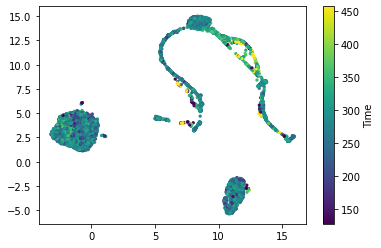

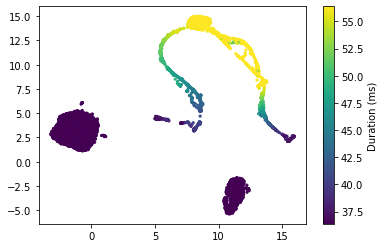

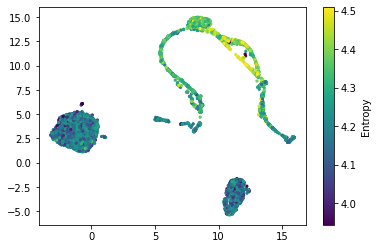

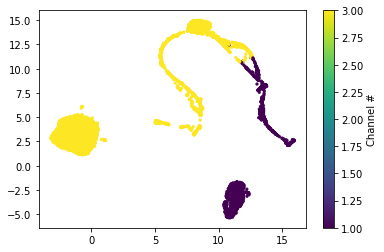

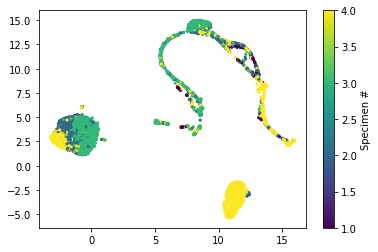

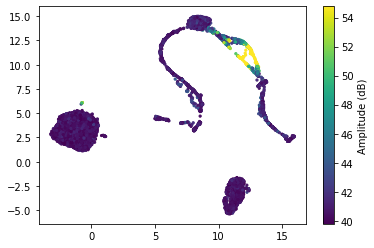

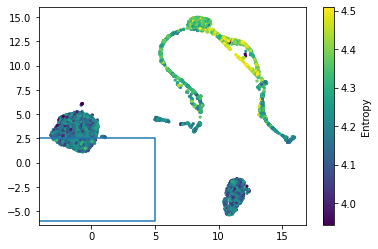

In [44]:
prefix = "Figures\\V04_"
save_figs = True
fig = lambda ID: f"{prefix}{ID}.png" if save_figs else None

plot_latent(flat, test_data.duration*test_data.interval*1e3, "Duration (ms)", fig(1))
plot_latent(flat, test_data.entropy, "Entropy",fig(2))
plot_latent(flat, test_data.channel, "Channel #",fig(3))
plot_latent(flat, test_data.test, "Specimen #",fig(4))
plot_latent(flat, test_data.amplitude, "Amplitude (dB)",fig(5))

plot_latent(flat, test_data.entropy, "Entropy", show=False)
xlim = plt.xlim(); ylim = plt.ylim()
box = [[-5,5],
       [ -6,  2.5]]
plt.plot(box[0]+box[0][::-1]+[box[0][0]], [box[1][0]]*2+[box[1][1]]*2+[box[1][0]])
plt.xlim(xlim); plt.ylim(ylim)
if save_figs:
       plt.savefig(fig(6), dpi=300)
plt.show()

##### Plotting of High-Entropy Cluster

In [31]:
cluster = np.array([box[0][0]<flat[i,0]<box[0][1] and box[1][0]<flat[i,1]<box[1][1] for i in range(flat.shape[0])])
reducer = umap.UMAP()
flat_cluster = reducer.fit_transform(test_data.latent[cluster,:])

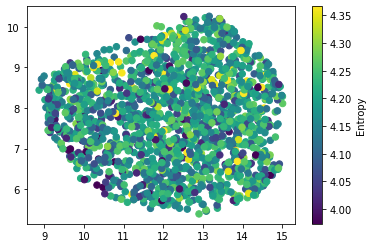

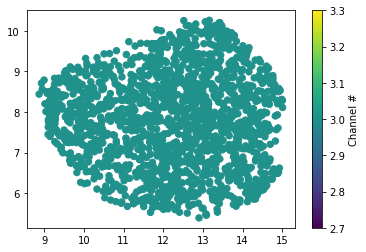

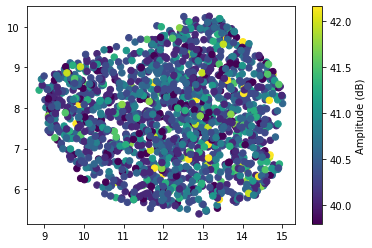

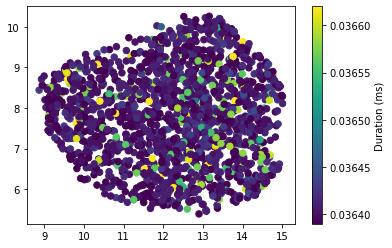

In [33]:
plot_latent(flat_cluster,test_data.entropy[cluster],"Entropy", fig(7))
plot_latent(flat_cluster,test_data.channel[cluster],"Channel #", fig(8))
plot_latent(flat_cluster,test_data.amplitude[cluster],"Amplitude (dB)", fig(9))
plot_latent(flat_cluster,test_data.duration[cluster]*test_data.interval[cluster],"Duration (ms)", fig(10))

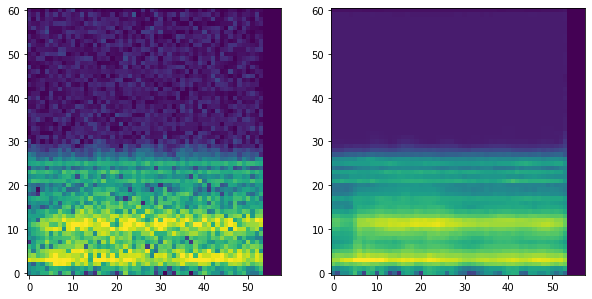

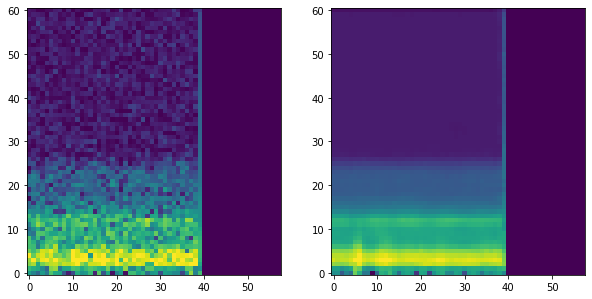

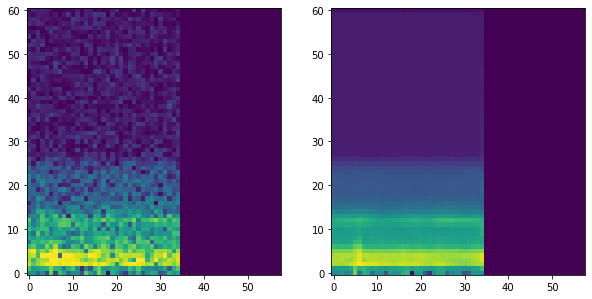

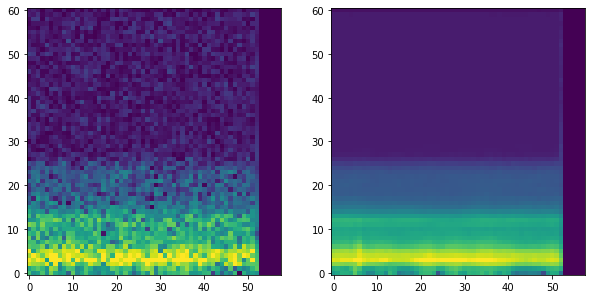

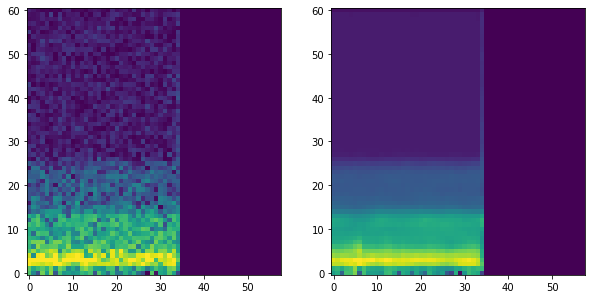

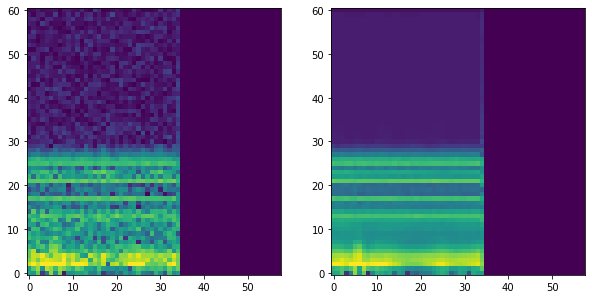

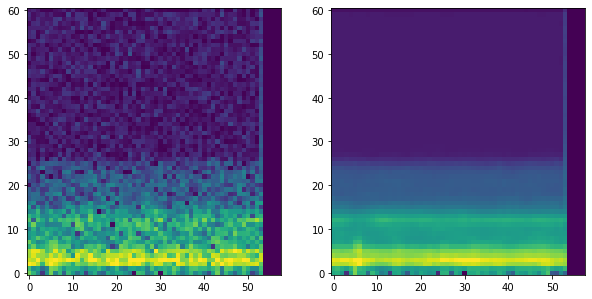

In [39]:
vmax = np.quantile(test_data.normalized, 0.99)
for i in range(0, len(test_data.hits), 2123):
        fig, ax = plt.subplots(1,2, figsize=(10,10))
        ax[0].imshow(test_data.normalized[i], origin="lower", vmin=0, vmax=vmax)
        ax[1].imshow(test_data.decoded[i], origin="lower", vmin=0, vmax=vmax)
plt.show()